# PDE-Learning of non-interacting fermions dynamics in $J_1-J_2$ model near Lifshitz critical point


In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import sys
import time
import numpy as np 
sys.path.insert(0, "../")

from PDE_search import *
from utils import save_dict, load_dict
from utils import generalized_euler_solver, get_euler_term_from_descr


import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

# Specifying matplotlib settings 
pylab.rcParams['figure.figsize'] = (5, 4)
params = {'legend.fontsize': 25,
         'axes.labelsize': 27,
         'axes.titlesize': 27,
         'xtick.labelsize': 20,
         'ytick.labelsize': 20,
         'lines.linewidth' : 2.5
         }
pylab.rcParams.update(params)

Populating the interactive namespace from numpy and matplotlib


# Here we consider Hamiltonian of the 1D fermion chain in the presence of next-nearest-neighbour hopping:
$$ H = -J_1 \sum_i (c^{+}_i c_{i+1} + c^+_{i+1} c_i)-J_2 \sum_i (c^{+}_i c_{i+2} + c^{+}_{i+2} c_i)$$

## First, let's have a look at the dataset

Text(0.5, 1.0, 'density, $\\rho(t, x)$')

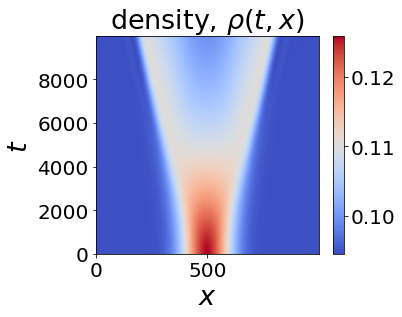

In [16]:
fname ='./data/free_fermions_J1=-0.5_J2=0.125.npy'
data_dict = load_dict(fname)

# Specifying time range
start, stop = 0, -1

# Density
rho = data_dict['n']
# Velocity
v = data_dict['v']

t = data_dict['t']
x = data_dict['x']

#################
# Reducing the number of temporal points in the dataset for faster computation
rho = rho[start:stop, :][::4]
v = v[start:stop, :][::4]
t = t[start:stop][::4]
#################

xx, tt = np.meshgrid(x, t)

plt.pcolormesh(xx, tt, rho, cmap='coolwarm')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')

plt.title(r'density, $\rho(t, x)$')

Text(0.5, 1.0, 'velocity, $v(t, x)$')

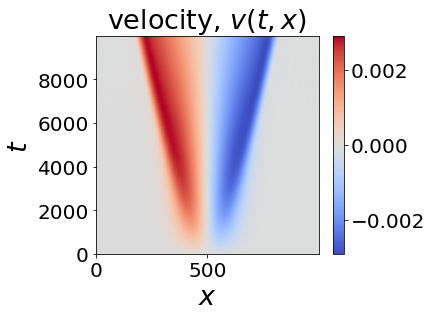

In [17]:
plt.pcolormesh(xx, tt, v, cmap='coolwarm')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'velocity, $v(t, x)$')

In [18]:
dt = t[1]-t[0]
dx = x[1]-x[0]

print('Dataset dimensions: ', rho.shape)
print('Xmax, Tmax: ', x[-1], t[-1])

Dataset dimensions:  (500, 1000)
Xmax, Tmax:  999 9980


## Preparing library of candidate terms: $\mathbf{U}_t=\Theta(\mathbf{U})\cdot \xi$

In [19]:
# Define boundary conditions, needed for evaluation of spatial derivatives
bc = "periodic"

# Compute temporal and spatial derivatives and build Theta(U) matrix
m,n = rho.shape

rhot = TotalFiniteDiff_t(rho, dt).reshape((n*m,1))
vt = TotalFiniteDiff_t(v, dt).reshape((n*m,1))
rhox = TotalFiniteDiff(rho, dx, 1, bc=bc).reshape((n*m,1))
rhoxx = TotalFiniteDiff(rho, dx, 2, bc=bc).reshape((n*m,1))

vx = TotalFiniteDiff(v, dx, 1, bc=bc).reshape((n*m,1))
vxx = TotalFiniteDiff(v, dx, 2, bc=bc).reshape((n*m,1))
rho_ = rho.reshape((n*m,1))
v_ = v.reshape((n*m,1))
const = np.ones((n*m, 1))

# You could modify the library of candidate terms
# Note, that BruteForce method becomes infeasible for >20 terms
v_descr = [
          'rho_x',
           'v*v_x',
           'v^2*rho_x',
           'v^2*rho*rho_x',
#            'v^2*rho^2*rho_x',
#            'v^2*rho^3*rho_x',
#            'v^2*rho^4*rho_x',
#            'v^2*rho^5*rho_x',
           'v^2*rho_x*1/rho',
           'rho*v*v_x',
           'rho^2*v*v_x',
           'rho^3*v*v_x',
           'rho^4*v*v_x', 
           'rho^5*v*v_x', 
           'rho*rho_x', 
           'rho^2*rho_x', 
           'rho^3*rho_x',
           'rho^4*rho_x',
           'rho^5*rho_x',]

v_data = []
for term in v_descr:
    v_data.append(get_euler_term_from_descr(term, rho_, v_, x, bc))

v_data = np.hstack(v_data)
v_Theta, v_descr = build_custom_Theta(v_data, v_descr)

In [20]:
rho_descr = [ 'rho',
              'v',
              'rho_x',
              'v_x',
              'v*v_x',
              'rho*rho_x',
              'v*rho_x',
              'rho*v_x',
              'rho*v*rho_x',
              'rho^2*v_x',    
              'rho^2*v*rho_x',
              'rho^3*v_x',    
              'rho^3*v*rho_x',
              'rho^4*v_x',  
            ]

rho_data = []
for term in rho_descr:
    rho_data.append(get_euler_term_from_descr(term, rho_, v_, x, bc))

rho_data = np.hstack(rho_data)
rho_Theta, rho_descr = build_custom_Theta(rho_data, rho_descr)

In [21]:
print(r"Total number of terms for rho_t=F(.):", len(rho_descr))
print(r"Total number of terms for v_t=G(.):", len(v_descr))

Total number of terms for rho_t=F(.): 14
Total number of terms for v_t=G(.): 15


## Search PDE for density: $\rho_t = F(...)$

In [22]:
xi_rho, _ = BruteForceL0(rho_Theta, rhot, rho_descr, l0_penalty=1e-5,
                     verbose=False, lhs_descr='rho_t')

KeyboardInterrupt: 

Hooray! We recovered the exact continuity equation!

## Search PDE for velocity: $v_t = G(...)$

In [15]:
# Search for vt = ...
# Computation may take a while (~10 mins)
xi_v, _ = BruteForceL0(v_Theta, vt, v_descr, l0_penalty=1e-6, 
                       verbose=False, lhs_descr='v_t')

KeyboardInterrupt: 

## Now we solve the inferred hydrodynamic PDE

In [60]:
rho_ev, v_ev = generalized_euler_solver(v_descr, xi_v, 
                                        rho[0], v[0], t, x, 
                                        num_integrator_steps=50, 
                                        fix_vvx_term=False)

../utils.py:89: ComplexWarning: Casting complex values to real discards the imaginary part
  rho_ev[step, :] = rho.copy()
../utils.py:90: ComplexWarning: Casting complex values to real discards the imaginary part
  v_ev[step, :] = v.copy()


Text(0.5, 1.0, '$\\rho(x, t)$')

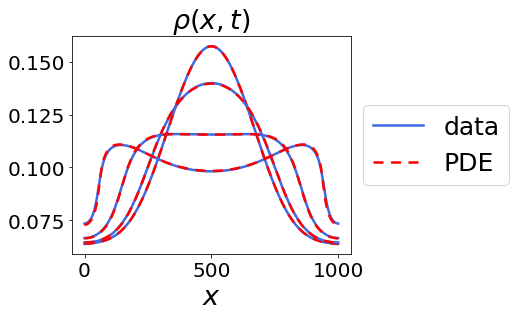

In [68]:
time_points = [0, 500, -1] 
for i, indx in enumerate(time_points):
    if i == 0:
        label1, label2 = 'data', 'PDE'
    else:
        label1, label2 = '', ''
    plt.plot(x, rho[indx, :],
             c='royalblue', label=label1)
    plt.plot(x, rho_ev[indx,:], 
             ls='--', c='red', dashes=(4,3), label=label2)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$x$')
plt.title(r'$\rho(x, t)$')